In [156]:
import time
notebookstart= time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc

# Modeling
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Debug = False

# Read data
NROWS = 6000000
if Debug is True: NROWS = 5000
train = pd.read_csv('train.csv', nrows = NROWS, index_col = "key")
train = train.dropna()
test_df = pd.read_csv('test.csv', index_col = "key")
testdex = test_df.index

# 1.0 Cleaning and Feature Engineering: 

There are a few anomalies in the fair and passenger_count features which are absent from the test set. Therefore, I shall remove them.

In [157]:
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
key,,,,,,,
2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [158]:
def prepare_distance_features(df):
    # Distance is expected to have an impact on the fare
    df['longitude_distance'] = abs(df['pickup_longitude'] - df['dropoff_longitude'])
    df['latitude_distance'] = abs(df['pickup_latitude'] - df['dropoff_latitude'])

    # Straight distance
    df['distance_travelled'] = (df['longitude_distance'] ** 2 + df['latitude_distance'] ** 2) ** .5
    df['distance_travelled_sin'] = np.sin((df['longitude_distance'] ** 2 * df['latitude_distance'] ** 2) ** .5)
    df['distance_travelled_cos'] = np.cos((df['longitude_distance'] ** 2 * df['latitude_distance'] ** 2) ** .5)
    df['distance_travelled_sin_sqrd'] = np.sin((df['longitude_distance'] ** 2 * df['latitude_distance'] ** 2) ** .5) ** 2
    df['distance_travelled_cos_sqrd'] = np.cos((df['longitude_distance'] ** 2 * df['latitude_distance'] ** 2) ** .5) ** 2

    # Haversine formula for distance
    # Haversine formula:	a = sin²(Δφ/2) + cos φ1 ⋅ cos φ2 ⋅ sin²(Δλ/2)
    R = 6371e3 # Metres
    phi1 = np.radians(df['pickup_latitude'])
    phi2 = np.radians(df['dropoff_latitude'])
    phi_chg = np.radians(df['pickup_latitude'] - df['dropoff_latitude'])
    delta_chg = np.radians(df['pickup_longitude'] - df['dropoff_longitude'])
    a = np.sin(phi_chg / 2) + np.cos(phi1) * np.cos(phi2) * np.sin(delta_chg / 2)
    c = 2 * np.arctan2(a ** .5, (1-a) ** .5)
    d = R * c
    df['haversine'] = d

    # Bearing
    # Formula:	θ = atan2( sin Δλ ⋅ cos φ2 , cos φ1 ⋅ sin φ2 − sin φ1 ⋅ cos φ2 ⋅ cos Δλ )
    y = np.sin(delta_chg * np.cos(phi2))
    x = np.cos(phi1) * np.sin(phi2) - np.sin(phi1) * np.cos(phi2) * np.cos(delta_chg)
    df['bearing'] = np.arctan2(y, x)
    return df

In [159]:
def prepare_time_features(df):
    df['pickup_datetime'] = df['pickup_datetime'].str.replace(" UTC", "")
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
    df['hour_of_day'] = df.pickup_datetime.dt.hour
    df['week'] = df.pickup_datetime.dt.week
    df['month'] = df.pickup_datetime.dt.month
    df["year"] = df.pickup_datetime.dt.year
    df['day_of_year'] = df.pickup_datetime.dt.dayofyear
    df['week_of_year'] = df.pickup_datetime.dt.weekofyear
    df["weekday"] = df.pickup_datetime.dt.weekday
    df["quarter"] = df.pickup_datetime.dt.quarter
    df["day_of_month"] = df.pickup_datetime.dt.day
    
    return df

In [160]:
def dist(pickup_lat, pickup_long, dropoff_lat, dropoff_long):  
    distance = np.abs(dropoff_lat - pickup_lat) + np.abs(dropoff_long - pickup_long)
    
    return distance

def airport_feats(train,test_df):
    for data in [train,test_df]:
        nyc = (-74.0063889, 40.7141667)
        jfk = (-73.7822222222, 40.6441666667)
        ewr = (-74.175, 40.69)
        lgr = (-73.87, 40.77)
        data['distance_to_center'] = dist(nyc[1], nyc[0],
                                          data['pickup_latitude'], data['pickup_longitude'])
        data['pickup_distance_to_jfk'] = dist(jfk[1], jfk[0],
                                             data['pickup_latitude'], data['pickup_longitude'])
        data['dropoff_distance_to_jfk'] = dist(jfk[1], jfk[0],
                                               data['dropoff_latitude'], data['dropoff_longitude'])
        data['pickup_distance_to_ewr'] = dist(ewr[1], ewr[0], 
                                              data['pickup_latitude'], data['pickup_longitude'])
        data['dropoff_distance_to_ewr'] = dist(ewr[1], ewr[0],
                                               data['dropoff_latitude'], data['dropoff_longitude'])
        data['pickup_distance_to_lgr'] = dist(lgr[1], lgr[0],
                                              data['pickup_latitude'], data['pickup_longitude'])
        data['dropoff_distance_to_lgr'] = dist(lgr[1], lgr[0],
                                               data['dropoff_latitude'], data['dropoff_longitude'])
    return train, test_df

In [161]:
#Percentile
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

# Build ime Aggregate Features
def time_agg(train, test_df, vars_to_agg, vars_be_agg):
    for var in vars_to_agg:
        agg = train.groupby(var)[vars_be_agg].agg(["sum","mean","std","skew",percentile(80),percentile(20)])
        if isinstance(var, list):
            agg.columns = pd.Index(["fare_by_" + "_".join(var) + "_" + str(e) for e in agg.columns.tolist()])
        else:
            agg.columns = pd.Index(["fare_by_" + var + "_" + str(e) for e in agg.columns.tolist()])
        agg.reset_index(inplace=True,level=0)    
        train = train.merge(agg, left_on = var,right_on = var, how= "left")
        test_df = test_df.merge(agg, left_on = var,right_on = var, how= "left")
    
    return train, test_df

In [162]:
var = 'passenger_count'
agg = train.groupby('passenger_count',as_index=False)["fare_amount"].agg(["sum","mean","std","skew",percentile(80),percentile(20)])
agg.columns = pd.Index(["fare_by_" + var + "_" + str(e) for e in agg.columns.tolist()])
agg.reset_index(inplace=True,level=0)

In [163]:
agg

,passenger_count,fare_by_passenger_count_sum,fare_by_passenger_count_mean,fare_by_passenger_count_std,fare_by_passenger_count_skew,fare_by_passenger_count_percentile_80,fare_by_passenger_count_percentile_20
0,0,1.909662e+05,9.018476,6.348243,3.870227,11.700,4.900
1,1,4.653675e+07,11.212155,9.725208,4.852636,14.000,5.500
2,2,1.047685e+07,11.822857,10.361590,4.339470,14.900,5.700
3,3,3.040408e+06,11.551440,9.782057,3.567055,14.500,5.700
4,4,1.501079e+06,11.787404,10.195323,4.339295,14.500,5.700
5,5,4.755894e+06,11.198192,9.330026,3.108056,14.100,5.500
6,6,1.540022e+06,12.144809,10.143850,2.856957,15.500,6.000
7,7,8.500000e+00,8.500000,NaN,NaN,8.500,8.500
8,9,1.410400e+02,70.520000,47.347870,NaN,90.608,50.432
9,51,9.300000e+00,9.300000,NaN,NaN,9.300,9.300


In [164]:
# Clean dataset 
def clean_df(df):
    return df[(df.fare_amount > 0) & 
            (df.pickup_longitude > -80) & (df.pickup_longitude < -70) &
            (df.pickup_latitude > 35) & (df.pickup_latitude < 45) &
            (df.dropoff_longitude > -80) & (df.dropoff_longitude < -70) &
            (df.dropoff_latitude > 35) & (df.dropoff_latitude < 45)]
print("Cleaning Functions Defined..")

Cleaning Functions Defined..


# Run All Pre-Processing and Cleaning:

In [165]:
print("Percent of Training Set with Zero and Below Fair: ", round(((train.loc[train["fare_amount"] <= 0, "fare_amount"].shape[0]/train.shape[0]) * 100),5))
print("Percent of Training Set 200 and Above Fair: ", round((train.loc[train["fare_amount"] >= 200, "fare_amount"].shape[0]/train.shape[0]) * 100,5))
train = train.loc[(train["fare_amount"] > 0) & (train["fare_amount"] <= 200),:]
print("\nPercent of Training Set with Zero and Below Passenger Count: ", round((train.loc[train["passenger_count"] <= 0, "passenger_count"].shape[0]/train.shape[0]) * 100,5))
print("Percent of Training Set with Nine and Above Passenger Count: ", round((train.loc[train["passenger_count"] >= 9, "passenger_count"].shape[0]/train.shape[0]) * 100,5))
train = train.loc[(train["passenger_count"] > 0) & (train["passenger_count"] <= 9),:]

# Clean Training Set
train = clean_df(train)

# Distance Features
train = prepare_distance_features(train)
test_df = prepare_distance_features(test_df)
train,test_df = airport_feats(train,test_df)

# Time Features
train = prepare_time_features(train)
test_df = prepare_time_features(test_df)

# Ratios
train["fare_to_dist_ratio"] = train["fare_amount"] / ( train["distance_travelled"]+0.0001)
train["fare_npassenger_to_dist_ratio"] = (train["fare_amount"] / train["passenger_count"]) /( train["distance_travelled"]+0.0001)

# Time Aggregate Features
train, test_df = time_agg(train, test_df, vars_to_agg  = ["passenger_count", "weekday", "quarter", "month", "year", "hour_of_day"], vars_be_agg = "fare_amount")

Percent of Training Set with Zero and Below Fair:  0.00703
Percent of Training Set 200 and Above Fair:  0.00378

Percent of Training Set with Zero and Below Passenger Count:  0.35292
Percent of Training Set with Nine and Above Passenger Count:  0.00018


# 2.0 Understanding Time Range:

In [166]:
train_time_start = train.pickup_datetime.min()
train_time_end = train.pickup_datetime.max()
print("Train Time Starts: {}, Ends {}".format(train_time_start,train_time_end))
test_time_start = test_df.pickup_datetime.min()
test_time_end = test_df.pickup_datetime.max()
print("Test Time Starts: {}, Ends {}".format(test_time_start,test_time_end))

Train Time Starts: 2009-01-01 00:00:46, Ends 2015-06-30 23:59:45
Test Time Starts: 2009-01-01 11:04:24, Ends 2015-06-30 20:03:50


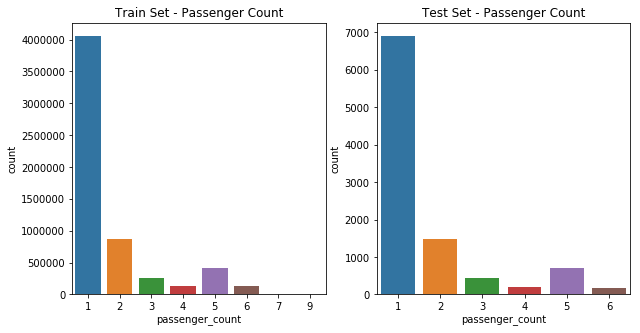

In [167]:
f, ax = plt.subplots(1,2,figsize = [10,5])
sns.countplot(train["passenger_count"], ax=ax[0])
sns.countplot(test_df["passenger_count"], ax=ax[1])
ax[0].set_title("Train Set - Passenger Count")
ax[1].set_title("Test Set - Passenger Count")
plt.show()

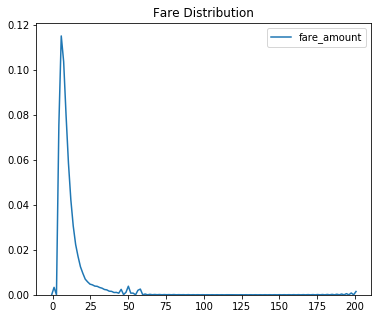

In [168]:
f, ax = plt.subplots(figsize=[6,5])
sns.kdeplot(train["fare_amount"], ax=ax)
ax.set_title("Fare Distribution")
plt.show()

In [169]:
def time_slicer(df, timeframes, value, color="purple"):
    """
    Function to count observation occurrence through different lenses of time.
    """
    f, ax = plt.subplots(len(timeframes), figsize = [12,12])
    for i,x in enumerate(timeframes):
        df.loc[:,[x,value]].groupby([x]).mean().plot(ax=ax[i],color=color)
        ax[i].set_ylabel(value.replace("_", " ").title())
        ax[i].set_title("{} by {}".format(value.replace("_", " ").title(), x.replace("_", " ").title()))
        ax[i].set_xlabel("")
    ax[len(timeframes)-1].set_xlabel("Time Frame")
    plt.tight_layout(pad=0)

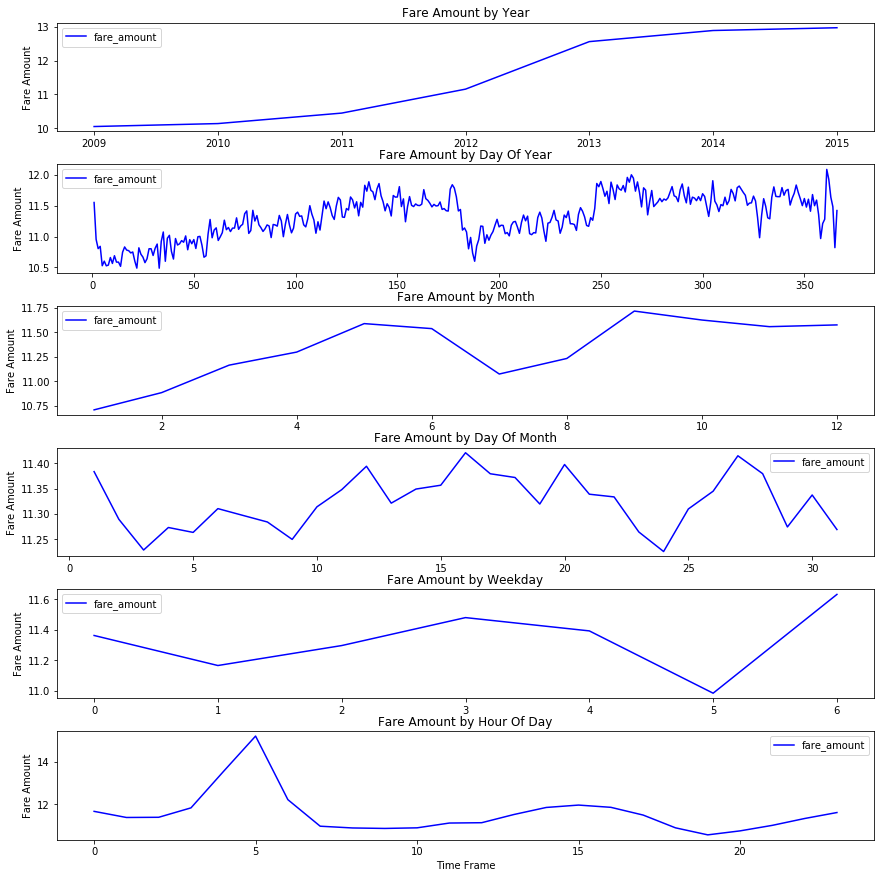

In [170]:
time_slicer(df=train, timeframes=['year',"day_of_year", "month", "day_of_month", "weekday", "hour_of_day"], value = "fare_amount", color="blue")

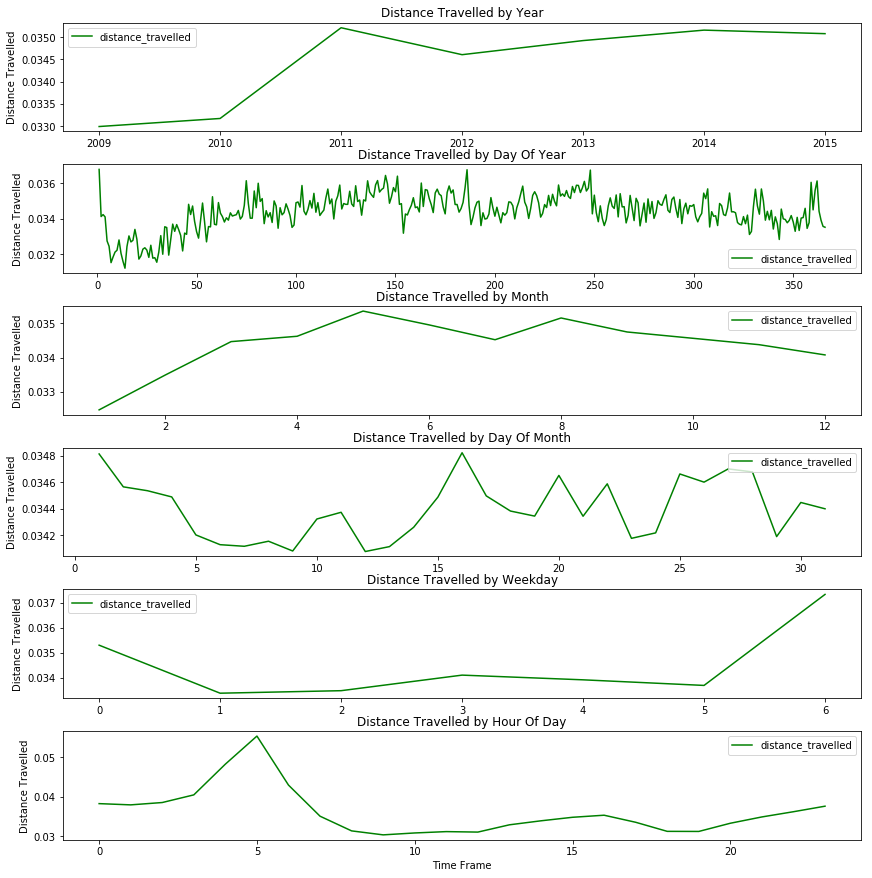

In [171]:
time_slicer(df=train, timeframes=['year',"day_of_year", "month", "day_of_month", "weekday", "hour_of_day"], value = "distance_travelled", color = "green")

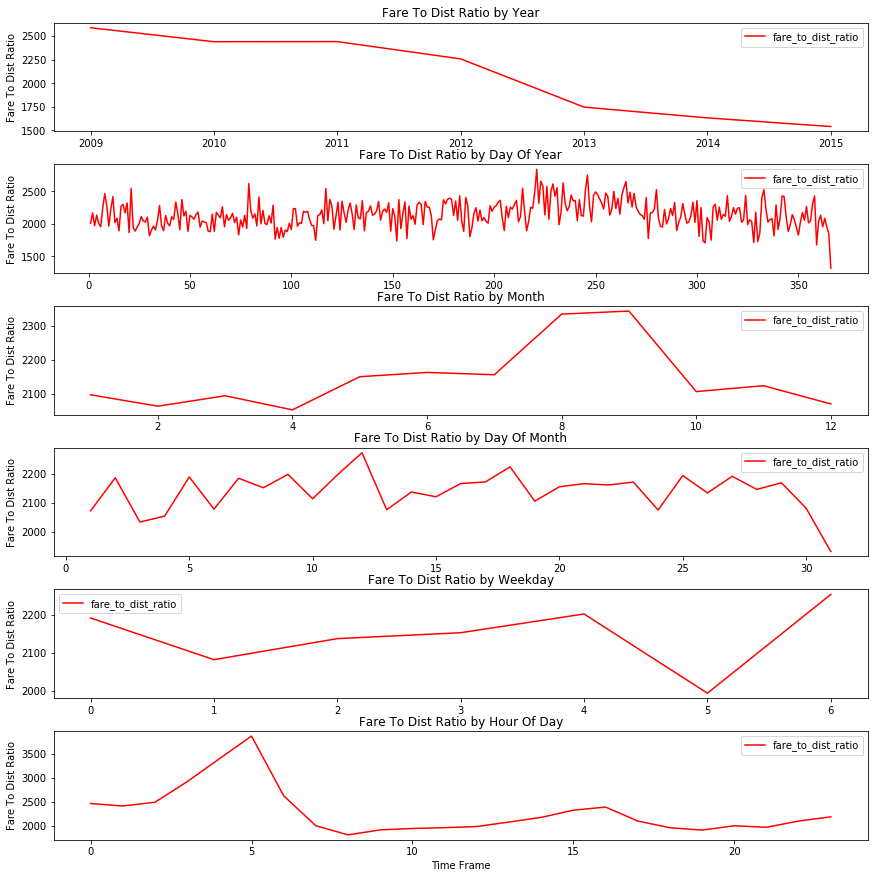

In [172]:
time_slicer(df=train, timeframes=['year',"day_of_year", "month", "day_of_month", "weekday", "hour_of_day"], value = "fare_to_dist_ratio", color = "red")

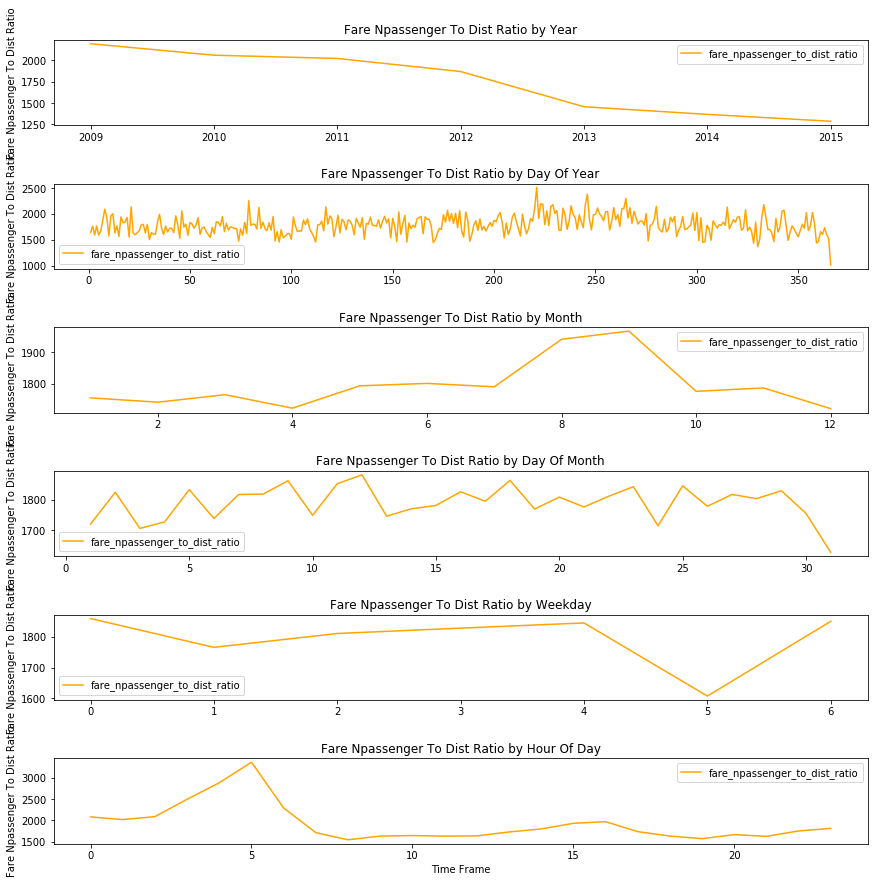

In [173]:
time_slicer(df=train, timeframes=['year',"day_of_year", "month", "day_of_month", "weekday", "hour_of_day"], value = "fare_npassenger_to_dist_ratio", color = "orange")

# 3.0 Modeling with LGBM

In [174]:
# Keep Relevant Variables..
y = train.fare_amount.copy()
test_df.drop("pickup_datetime", axis = 1, inplace=True)
train = train[test_df.columns]
print("Does Train feature equal test feature?: ", all(train.columns == test_df.columns))
trainshape = train.shape
testshape = test_df.shape

# print("\nTrain DF..")
# train = reduce_mem_usage(train)
# print("\nTest DF..")
# test_df = reduce_mem_usage(test_df)

# LGBM Dataset Formating
dtrain = lgb.Dataset(train, label=y, free_raw_data=False)

Does Train feature equal test feature?:  True


In [179]:
print("Light Gradient Boosting Regressor: ")
lgbm_params =  {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse'
                }

folds = KFold(n_splits=5, shuffle=True, random_state=1)
fold_preds = np.zeros(testshape[0])
oof_preds = np.zeros(trainshape[0])
dtrain.construct()

# Fit 5 Folds
modelstart = time.time()
for trn_idx, val_idx in folds.split(train):
    clf = lgb.train(
        params=lgbm_params,
        train_set=dtrain.subset(trn_idx),
        valid_sets=[dtrain.subset(trn_idx),dtrain.subset(val_idx)],
        valid_names = ['train','valid'],
        num_boost_round=3500, 
        early_stopping_rounds=125,
        verbose_eval=500
    )
    oof_preds[val_idx] = clf.predict(dtrain.data.iloc[val_idx])
    fold_preds += clf.predict(test_df) / folds.n_splits
    print(mean_squared_error(y.iloc[val_idx], oof_preds[val_idx]) ** .5)
print("Model Runtime: %0.2f Minutes"%((time.time() - modelstart)/60))

Light Gradient Boosting Regressor: 
Training until validation scores don't improve for 125 rounds.
[500]	train's rmse: 3.32009	valid's rmse: 3.44017
[1000]	train's rmse: 3.18601	valid's rmse: 3.40837
[1500]	train's rmse: 3.09894	valid's rmse: 3.39618
[2000]	train's rmse: 3.03216	valid's rmse: 3.38945
[2500]	train's rmse: 2.97783	valid's rmse: 3.38579
Early stopping, best iteration is:
[2699]	train's rmse: 2.95823	valid's rmse: 3.38441
3.3844058623036046
Training until validation scores don't improve for 125 rounds.
[500]	train's rmse: 3.31629	valid's rmse: 3.4654
[1000]	train's rmse: 3.18222	valid's rmse: 3.42734
[1500]	train's rmse: 3.0948	valid's rmse: 3.41407
[2000]	train's rmse: 3.02945	valid's rmse: 3.40787
[2500]	train's rmse: 2.97528	valid's rmse: 3.40441
[3000]	train's rmse: 2.92866	valid's rmse: 3.40142
Early stopping, best iteration is:
[3090]	train's rmse: 2.9204	valid's rmse: 3.40078
3.400776396266435
Training until validation scores don't improve for 125 rounds.
[500]	trai

In [180]:
lgsub = pd.DataFrame(fold_preds,columns=["fare_amount"],index=testdex)
lgsub.to_csv("lgsub.csv",index=True,header=True)

print("Notebook Runtime: %0.2f Minutes"%((time.time() - notebookstart)/60))
lgsub.head()

Notebook Runtime: 81.47 Minutes


,fare_amount
key,
2015-01-27 13:08:24.0000002,10.373192
2015-01-27 13:08:24.0000003,11.391929
2011-10-08 11:53:44.0000002,4.662641
2012-12-01 21:12:12.0000002,9.008853
2012-12-01 21:12:12.0000003,16.547256


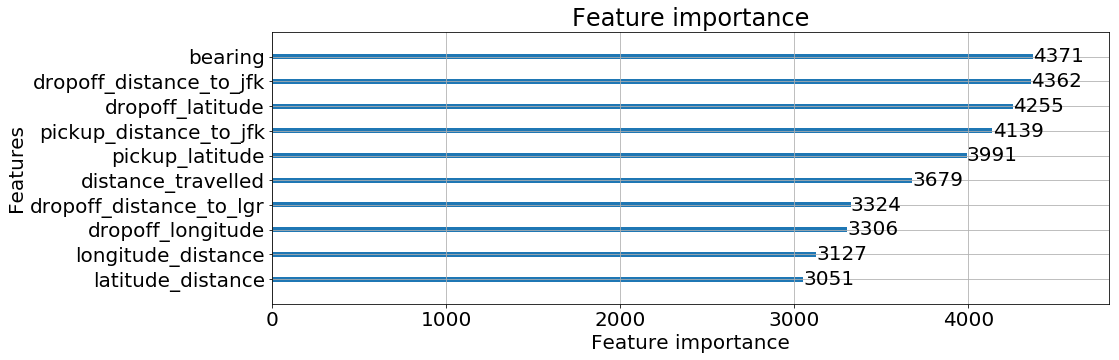

In [247]:
plt.rcParams.update({'font.size': 20})
f = plt.figure(figsize=(10,5))
ax = f.add_subplot()
lgb.plot_importance(clf,max_num_features=10,ax=ax,figsize=(15,5))
plt.show()